# 1. Daily closing prices for Facebook

## Obtain and plot price data

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv, solve, det
from scipy.optimize import leastsq

r = requests.get('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=MSFT&apikey=83SCGSM1BQW0WE86&datatype=csv')
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=FB&outputsize=full&apikey=83SCGSM1BQW0WE86&datatype=csv'
source = requests.get(url).content.decode().split("\n")

data = pd.read_csv(url, index_col=0, parse_dates=True)
data.head()
data['close'].plot()
plt.show()

<Figure size 640x480 with 1 Axes>

In [3]:
# Further data work and saving to .csv

data.head()
data.to_csv('FBprices.csv')

**Notes and current to-dos:**

* (DONE) Store dataset
* More companies (note can only request from Alpha Vantage five times every min)
* Update and store data in a structured, separate panel dataset created by the queries that is regularly updated - initial work will happen on this
* Basic summary stats for prices - this will later become an indicator table
* Non-price indicators, e.g. other financial data (may have to pull this from another source)

## First go at estimating the model

In [9]:
## 1. Variable creation

# Column vector of ones (intercept)

data['const'] = 1

# Time counter

data['t'] = range(len(data['const']))

# Containers for the non-linear parameters w initial values

data['tc'] = len(data['const'])+1 # currently tomorrow
data['m'] = np.random.uniform(0, 1) # recommended filter bound
data['ω'] = np.random.randint(4, 26) # recommended filter bound; integers for simplicity

# Dependent variables (f, g, and h)

data['f'] = (data['tc']-data['t'])**data['m']
data['g'] = ((data['tc']-data['t'])**data['m'])*np.cos(data['ω']*np.log(data['tc']-data['t']))
data['h'] = ((data['tc']-data['t'])**data['m'])*np.sin(data['ω']*np.log(data['tc']-data['t']))

## 2. Slaving the linear parameters (OLS estimates)

X = np.array([data['const'], data['f'], data['g'], data['h']]).T
p = np.array([data['close']]).T
y = np.log(p)

β_hat = inv(X.T @ X) @ X.T @ y

# Extracting slaved linear parameter estimates

A_hat = β_hat[0]
B_hat = β_hat[1]
C_1_hat = β_hat[2]
C_2_hat = β_hat[3]

## 3. Estimating the non-linear parameters

# Squared residuals

data['A_hat'] = data['const']*A_hat # Gives it the proper dimensions
data['y'] = y

data['sqresid'] = (data['y'] - data['A_hat'] - B_hat*data['f'] - C_1_hat*data['g'] - C_2_hat*data['h'])**2

# Sum of squared residuals

data['ssr'] = data['sqresid'].sum()

data.head()

# This works, but the way that I've written the variables doesn't make it easy to do NLS on...

##SPARE CODE BEGINS HERE

# data.head()

#del df['column_name'] - reminder code for deleting variables

#Optional container code below (simple loop)

#nonlinparams = ['tc', 'm', 'ω']

#for i in nonlinparams:
 #   data[i] = ""
    
#To improve the fit for future, use 'lmfit' from http://cars9.uchicago.edu/software/python/lmfit/lmfit.pdf)

,open,high,low,close,volume,const,t,tc,m,ω,f,g,h,A_hat,y,sqresid,ssr
timestamp,,,,,,,,,,,,,,,,,
2018-09-24,161.03,165.5800,160.8800,165.28,14497294,1,0,1599,0.020418,9,1.162559,-1.061161,-0.474850,-25.846201,5.107641,0.008314,135.107435
2018-09-21,166.64,167.2500,162.8100,162.93,45994800,1,1,1599,0.020418,9,1.162545,-1.063804,-0.468862,-25.846201,5.093321,0.005897,135.107435
2018-09-20,164.50,166.4500,164.4722,166.02,18936038,1,2,1599,0.020418,9,1.162530,-1.066415,-0.462855,-25.846201,5.112108,0.009122,135.107435
2018-09-19,160.08,163.4400,159.4800,163.06,19628996,1,3,1599,0.020418,9,1.162515,-1.068993,-0.456830,-25.846201,5.094118,0.005998,135.107435
2018-09-18,159.39,161.7639,158.8656,160.30,22465236,1,4,1599,0.020418,9,1.162500,-1.071540,-0.450787,-25.846201,5.077047,0.003637,135.107435


## Second go at estimating the model

In [40]:
## Variables

# Intercept (column vector of ones)

data['const'] = 1

# Time counter

data['t'] = range(len(data['const']))

# Initial values

data['tc'] = len(data['const'])+1 # currently tomorrow
data['m'] = np.random.uniform(0, 1) # recommended filter bound
data['ω'] = np.random.randint(4, 26) # recommended filter bound; integers for simplicity

# Defining function to minimize

const = np.array(data['const'])
x0 = np.array([data['tc'],data['m'],data['ω']])
t = np.array(data['t'])
p = np.array(data['close']).T
y = np.log(p)
                 
def f(x0, t):
    return x0[0] - t**x0[1]

def g(x0, t):
    return ((x0[0]-t)**x0[1])*np.cos(x0[2]*np.log(x0[0]-t))
               
def h(x0,t):
    return ((x0[0]-t)**x0[1])*np.sin(x0[2]*np.log(x0[0]-t))

def X(const, x0, t):
    return np.array([const, f(x0,t), g(x0,t), h(x0,t)]).T

def β_hat(const, x0, t):
    return inv(X(const, x0, t).T @ X(const, x0, t)) @ X(const, x0, t).T @ y

def residual(const, x0, t):
    
    A_hat = const*β_hat(const,x0,t)[0]
    B_hat = β_hat(const,x0,t)[1]
    C_1_hat = β_hat(const,x0,t)[2]
    C_2_hat = β_hat(const,x0,t)[3]

    return y - A_hat - B_hat*f(x0,t) - C_1_hat*g(x0,t) - C_2_hat*h(x0,t)

#nlparams = leastsq(residual, x0, args=(const, t))

print(residual(const,x0,t))

# This all works, except for the 'leastsq' command which doesn't seem to like matrices

# I'm going to start here next time and calculate the NLS equations and optimization algorithm myself

[-0.66969397 -0.66165274 -0.62969418 ...  0.01152131  0.10556627
  0.22115864]


## Take three...

In [53]:
## Variables

# Intercept (column vector of ones)

data['const'] = 1

# Time counter

data['t'] = range(len(data['const']))

# Initial values

data['tc'] = len(data['const'])+1
data['m'] = 0.5
data['ω'] = 5

# Other inputs

const = np.array(data['const'])
x0 = np.array([data['tc'],data['m'],data['ω']])
t = np.array(data['t'])
p = np.array(data['close']).T
y = np.log(p)

# Defining functions to minimise to OLS

def f(x0, t):
    return x0[0] - t**x0[1]

def g(x0, t):
    return ((x0[0]-t)**x0[1])*np.cos(x0[2]*np.log(x0[0]-t))
               
def h(x0,t):
    return ((x0[0]-t)**x0[1])*np.sin(x0[2]*np.log(x0[0]-t))

def X(const, x0, t):
    return np.array([const, f(x0,t), g(x0,t), h(x0,t)]).T

# OLS estimators - use key below to avoid errors when copying over the Wolfram solution

N = t
a = (f(x0,t).sum())
b = (g(x0,t).sum())
c = (h(x0,t).sum())
d = ((f(x0,t)**2).sum())
e = ((f(x0,t)*g(x0,t)).sum())
f = ((f(x0,t)*h(x0,t)).sum())
g1 = ((g(x0,t)**2).sum()) #renamed to avoid shadowing
j = ((h(x0,t)**2).sum())
h = ((g(x0,t)*h(x0,t)).sum())

denom = 1/(((-a**2)*g*j) + (a**2)*(h**2) - 2*c(a*e*h - a*f*g - b*d*h + b*e*f) + (a*b)*(2*e*j-2*f*h) + (b**2)*((f**2)-d*j)+(c**2)*((e**2)-d*g) + d*g*j*N - d*(h**2)*N - (e**2)*j*N + 2*e*f*h*N - (f**2)*g*N)

# Pasting in the terms gives...

denom = 1/(((-(f(x0,t).sum())**2)* ((g(x0,t)**2).sum())*((h(x0,t)**2).sum())) + ((f(x0,t).sum())**2)*( ((g(x0,t)*h(x0,t)).sum())**2) - 2*(h(x0,t).sum())((f(x0,t).sum())*((f(x0,t)*g(x0,t)).sum())*((g(x0,t)*h(x0,t)).sum()) - (f(x0,t).sum())*((f(x0,t)*h(x0,t)).sum())*((g(x0,t)**2).sum()) - (g(x0,t).sum())*((f(x0,t)**2).sum())*((g(x0,t)*h(x0,t)).sum()) + (g(x0,t).sum())*((f(x0,t)*g(x0,t)).sum())*((f(x0,t)*h(x0,t)).sum())) + ((f(x0,t).sum())*(g(x0,t).sum()))*(2*((f(x0,t)*g(x0,t)).sum())*((h(x0,t)**2).sum())-2*((f(x0,t)*h(x0,t)).sum())*((g(x0,t)*h(x0,t)).sum())) + ((g(x0,t).sum())**2)*(( ((f(x0,t)*h(x0,t)).sum())**2)-((f(x0,t)**2).sum())*((h(x0,t)**2).sum()))+((h(x0,t).sum())**2)*((((f(x0,t)*g(x0,t)).sum())**2)-((f(x0,t)**2).sum())*((g(x0,t)**2).sum())) + ((f(x0,t)**2).sum())*((g(x0,t)**2).sum())*((h(x0,t)**2).sum())*t - ((f(x0,t)**2).sum())*(((g(x0,t)*h(x0,t)).sum())**2)*t - (((f(x0,t)*g(x0,t)).sum())**2)*((h(x0,t)**2).sum())*t + 2*((f(x0,t)*g(x0,t)).sum())*((f(x0,t)*h(x0,t)).sum())*((g(x0,t)*h(x0,t)).sum())*t - (((f(x0,t)*h(x0,t)).sum())**2)* ((g(x0,t)**2).sum())*t)

print(denom)

# UP TO HERE: getting errors when defining stuff, so will stop here and try another approach

#def A_hat(x0, t): #here we go...
 #   return (-(((h(x0,t))**2).sum())*((f(x0,t)*g(x0,t)).sum())**2) + 2*((f(x0,t)*h(x0,t)).sum())

#print(A_hat(x0,t))

#def β_hat_check(const, x0, t): 
 #   return inv(X(const, x0, t).T @ X(const, x0, t)) @ X(const, x0, t).T @ y

#def residual(const, x0, t):
    
 #   A_hat_check = const*β_hat_check(const,x0,t)[0]
  #  B_hat_check = β_hat_check(const,x0,t)[1]
   # C_1_hat_check = β_hat_check(const,x0,t)[2]
    #C_2_hat_check = β_hat_check(const,x0,t)[3]

    #return y - A_hat - B_hat*f(x0,t) - C_1_hat*g(x0,t) - C_2_hat*h(x0,t)

#nlparams = leastsq(residual, x0, args=(const, t))

#print(residual(const,x0,t))

TypeError: unsupported operand type(s) for *: 'float' and 'function'

## Take four

In [107]:
## Load dataset obtained earlier

data = pd.read_csv('FBprices.csv', index_col=0, parse_dates=True)

#Start with the approach from Attempt 2

## Variables

# Intercept (column vector of ones)

data['const'] = 1

# Time counter

data['t'] = list(reversed(range(len(data['const']))))

# Initial values

tc = len(data['const'])+1 # tomorrow
m = 0.5 # within recommended filter bound
ω = 10 # within recommended filter bound

# Definitions and functions

const = np.array(data['const'])
x0 = np.array([tc,m,ω])
t = np.array(data['t'])
p = np.array(data['close']).T
y = np.log(p)

def f(x0, t):
    return x0[0] - t**x0[1]

def g(x0, t):
    return ((x0[0]-t)**x0[1])*np.cos(x0[2]*np.log(x0[0]-t))
               
def h(x0,t):
    return ((x0[0]-t)**x0[1])*np.sin(x0[2]*np.log(x0[0]-t))

def X(const, x0, t):
    return np.array([const, f(x0,t), g(x0,t), h(x0,t)]).T

def β_hat(const, x0, t):
    return inv(X(const, x0, t).T @ X(const, x0, t)) @ X(const, x0, t).T @ y

def residual(const, x0, t):
    
    A_hat = const*β_hat(const,x0,t)[0]
    B_hat = β_hat(const,x0,t)[1]
    C_1_hat = β_hat(const,x0,t)[2]
    C_2_hat = β_hat(const,x0,t)[3]
    
    return y - A_hat - B_hat*f(x0,t) - C_1_hat*g(x0,t) - C_2_hat*h(x0,t)

## Non-linear least squares

# Approximating the Jacobian via finite differences

δ = 0.0001 #adjustable perturbation

tc_perturb_plus = np.array([tc+δ,m,ω])
tc_perturb_minus = np.array([tc-δ,m,ω])
m_perturb_plus = np.array([tc,m+δ,ω])
m_perturb_minus = np.array([tc,m-δ,ω])
ω_perturb_plus = np.array([tc,m,ω+δ])
ω_perturb_minus = np.array([tc,m,ω-δ])

def J(const, x0, t):
    
    tc_dev = (residual(const, tc_perturb_plus, t) - residual(const, tc_perturb_minus, t)) / 2*δ
    m_dev = (residual(const, m_perturb_plus, t) - residual(const, m_perturb_minus, t)) / 2*δ
    ω_dev = (residual(const, ω_perturb_plus, t) - residual(const, ω_perturb_minus, t)) / 2*δ
    
    return np.array([tc_dev, m_dev, ω_dev]).T
    
# Levenberg-Marquardt algorithm

iterations = 100 # adjust this as needed
λ = 1 # initial damping parameter
ssr0 = (residual(const, x0, t)**2).sum() # initial sum of squared residuals
i =0

while i<iterations:
    x1 = x0 - (inv(J(const, x0, t).T @ J(const, x0, t) + λ*np.identity(3)) @ J(const, x0, t).T @ residual(const, x0, t)) # tentative iterate
    ssr1 = (residual(const, x1, t)**2).sum()
    if ssr1 < ssr0:
        λ = 0.8*λ
        x0 = x1
        ssr0 = ssr1
        i = i+1
    else:
        λ = 2*λ
        ssr0 = ssr1

print(x0)
print(ssr0)

[1.60299987e+03 7.82873131e-01 1.00069612e+01]
25.96117780318623


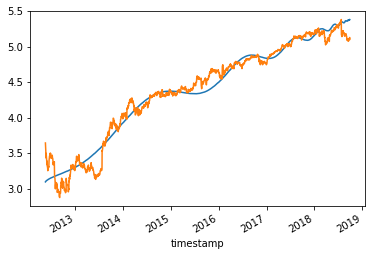

In [108]:
## Plotting the results

data['y_hat'] = const*β_hat(const,x0,t)[0] + β_hat(const,x0,t)[1]*f(x0,t) + β_hat(const,x0,t)[2]*g(x0,t) + β_hat(const,x0,t)[3]*h(x0,t)
data['y'] = y

data['y_hat'].plot()
data['y'].plot()
plt.show() # will be mirrored if loaded

## Historical tests

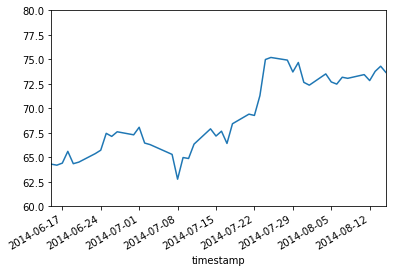

KeyError: "labels ['2018'] not contained in axis"

In [129]:
## Explorations

# Hypothetical positive bubble 1: Jun-Jul 2014 (started ~10 June; ended 25 July)

data['close'].plot()
plt.xlim('2014-06-15','2014-08-15') # change x-axis
plt.ylim(60,80) # change y-axis
plt.show() # will be mirrored if loaded

# Keeping relevant dates

# data['dates'] = data.index

# data.drop(pd.to_datetime('2018'))

# data.drop(data.index['2016':'2018'])

# data['2014-08-15':'2014-06-15']

#PREDICTED PARAMS: tc,m,ω with different rolling 30-day windows

#Full date range (hindsight):
#One day before:
#Two days before
#Three days before:
#A week before:




# CURRENT STEPS: fit the curve for just the subset of data

# Code for fitting models separately

# btime = ['2014-06-15','2014-08-15']
# data = data[data['date'].isin(btime)]

# Spare code

#del df['column_name'] - code for deleting variables
# - code for deleting obs

# Current to-dos: plot a given set of data; not enough obs to do daily?; other way to get fin; change 'data' refs to 'df'
# Other next steps; iterative fitting

# New way to get fin data: https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html